In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.tight_layout()
dataset = pd.read_parquet("../data/dataset3.parquet")

<Figure size 640x480 with 0 Axes>

array([[<AxesSubplot: title={'center': 'roll'}>,
        <AxesSubplot: title={'center': 'x'}>,
        <AxesSubplot: title={'center': 'y'}>,
        <AxesSubplot: title={'center': 'light_turn'}>,
        <AxesSubplot: title={'center': 'utility'}>],
       [<AxesSubplot: title={'center': 'light_score'}>,
        <AxesSubplot: title={'center': 'dark_score'}>,
        <AxesSubplot: title={'center': 'light_left'}>,
        <AxesSubplot: title={'center': 'dark_left'}>,
        <AxesSubplot: title={'center': 'rank'}>],
       [<AxesSubplot: title={'center': 'game0'}>,
        <AxesSubplot: title={'center': 'game1'}>,
        <AxesSubplot: title={'center': 'game2'}>,
        <AxesSubplot: title={'center': 'game3'}>,
        <AxesSubplot: title={'center': 'game4'}>],
       [<AxesSubplot: title={'center': 'game5'}>,
        <AxesSubplot: title={'center': 'game6'}>,
        <AxesSubplot: title={'center': 'game7'}>,
        <AxesSubplot: title={'center': 'game8'}>,
        <AxesSubplot: title={'

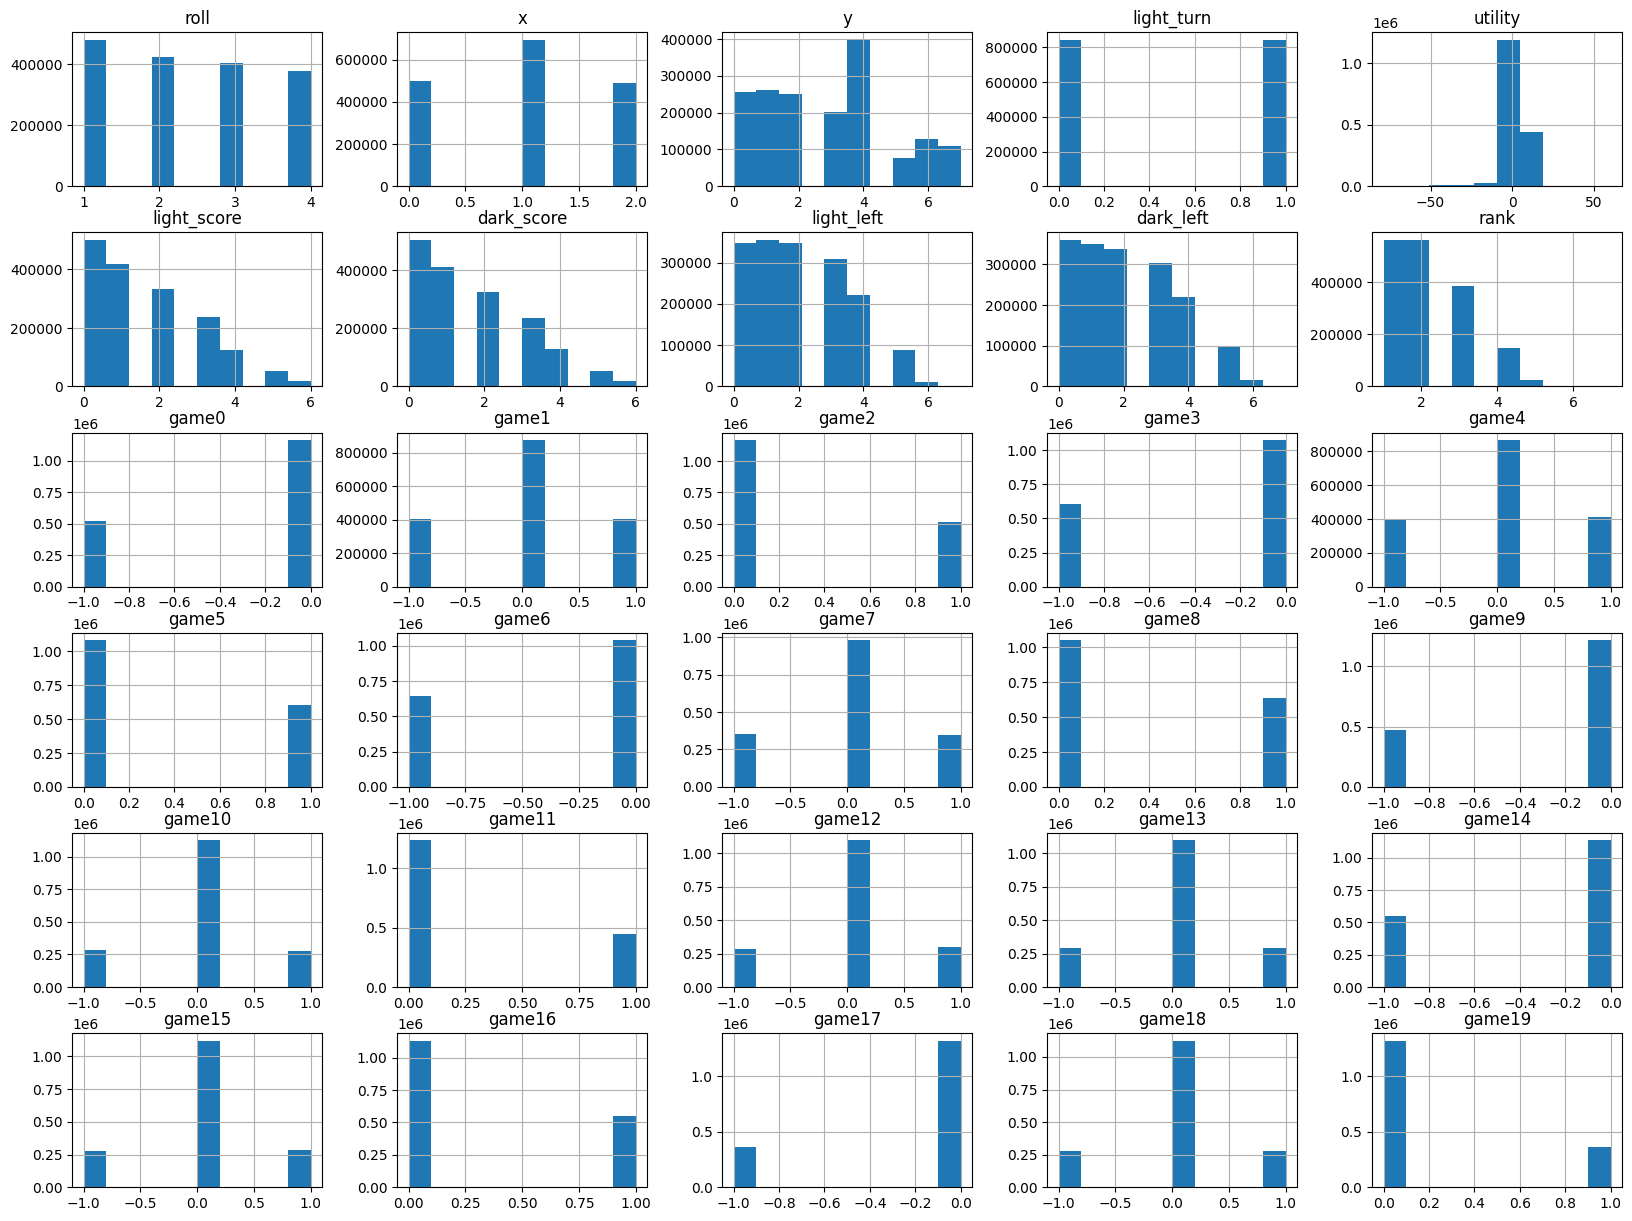

In [2]:
dataset.astype({'light_turn': 'int32'}).hist(figsize=(20, 15))

In [3]:
dataset.astype({'light_turn': 'int32'}).describe()

,roll,x,y,light_turn,utility,light_score,dark_score,light_left,dark_left,rank,...,game10,game11,game12,game13,game14,game15,game16,game17,game18,game19
count,1.682902e+06,1.682902e+06,1.682902e+06,1.682902e+06,1.682902e+06,1.682902e+06,1.682902e+06,1.682902e+06,1.682902e+06,1.682902e+06,...,1.682902e+06,1.682902e+06,1.682902e+06,1.682902e+06,1.682902e+06,1.682902e+06,1.682902e+06,1.682902e+06,1.682902e+06,1.682902e+06
mean,2.402588e+00,9.966647e-01,2.901092e+00,5.014249e-01,8.634082e-01,1.581291e+00,1.589579e+00,2.009396e+00,2.018025e+00,2.115615e+00,...,-3.004334e-03,2.665538e-01,8.699853e-03,-1.042247e-03,-3.267463e-01,2.994827e-04,3.278391e-01,-2.164202e-01,2.536095e-03,2.154594e-01
std,1.122782e+00,7.663048e-01,2.066102e+00,4.999981e-01,7.268149e+00,1.467034e+00,1.482382e+00,1.528498e+00,1.561517e+00,1.021826e+00,...,5.766756e-01,4.421572e-01,5.911700e-01,5.909290e-01,4.690238e-01,5.779350e-01,4.694260e-01,4.118041e-01,5.757642e-01,4.111408e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.871895e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-2.441072e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,1.009257e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.000000e+00,2.000000e+00,4.000000e+00,1.000000e+00,4.886028e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.000000e+00,2.000000e+00,7.000000e+00,1.000000e+00,6.023599e+01,6.000000e+00,6.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


In [5]:
pd.set_option('display.max_columns', None)
dataset.sample(n=50)

,game,roll,x,y,light_turn,utility,light_score,dark_score,light_left,dark_left,rank,game0,game1,game2,game3,game4,game5,game6,game7,game8,game9,game10,game11,game12,game13,game14,game15,game16,game17,game18,game19
135996,--- --D L-- -DD .-. .-. --D ---,3,0,4,True,0.574940,1,0,5,3,1,0,0,0,0,0,1,-1,0,0,0,1,1,0,0,0,0,1,0,0,0
1780987,-L- -LD -DD --D .-. .L. --- ---,3,2,3,False,12.234571,0,0,4,3,1,0,-1,0,0,-1,1,0,1,1,0,0,1,0,-1,0,0,0,0,0,0
320339,LLD LLD --D -D- .L. .-. LD- --D,1,1,6,False,3.689188,0,1,1,0,4,-1,-1,1,-1,-1,1,0,0,1,0,1,0,-1,0,-1,1,0,0,0,1
1094437,-L- L-- LL- -D- .-. .-. LDD ---,2,2,4,False,2.010838,1,2,1,2,1,0,-1,0,-1,0,0,-1,-1,0,0,1,0,0,0,-1,1,1,0,0,0
1065561,-D- --- -DD --- .L. .-. L-D L--,3,0,4,True,-5.066833,3,3,1,0,2,0,1,0,0,0,0,0,1,1,0,0,0,-1,0,-1,0,1,-1,0,0
357326,--- --- L-D LL- .D. .-. LD- ---,4,0,4,True,9.229717,2,4,1,0,1,0,0,0,0,0,0,-1,0,1,-1,-1,0,1,0,-1,1,0,0,0,0
184891,LD- --- -L- L-D .D. .-. L-- ---,1,0,3,True,-0.815515,0,1,3,3,4,-1,1,0,0,0,0,0,-1,0,-1,0,1,1,0,-1,0,0,0,0,0
1885258,-D- L-- L-- -DD .L. .D. L-- ---,3,0,2,True,4.016093,1,2,2,1,1,0,1,0,-1,0,0,-1,0,0,0,1,1,-1,1,-1,0,0,0,0,0
136405,-D- --- --D --D .L. .D. --- ---,3,0,4,True,-1.404584,1,0,5,3,1,0,1,0,0,0,0,0,0,1,0,0,1,-1,1,0,0,0,0,0,0
1078040,--D L-- --- L-- .D. .-. L-- -D-,3,0,3,True,4.841146,4,4,0,0,1,0,0,1,-1,0,0,0,0,0,-1,0,0,1,0,-1,0,0,0,1,0


In [91]:
dataset.columns

Index(['game', 'roll', 'x', 'y', 'light_turn', 'utility', 'light_score',
       'dark_score', 'light_left', 'dark_left', 'rank', 'game0', 'game1',
       'game2', 'game3', 'game4', 'game5', 'game6', 'game7', 'game8', 'game9',
       'game10', 'game11', 'game12', 'game13', 'game14', 'game15', 'game16',
       'game17', 'game18', 'game19'],
      dtype='object')

In [92]:
df_all_rolls = dataset.pivot_table(values='utility', index='y', columns='x')
df_roll_1 = dataset.query("roll == 1").pivot_table(values='utility', index='y', columns='x')
df_roll_2 = dataset.query("roll == 2").pivot_table(values='utility', index='y', columns='x')
df_roll_3 = dataset.query("roll == 3").pivot_table(values='utility', index='y', columns='x')
df_roll_4 = dataset.query("roll == 4").pivot_table(values='utility', index='y', columns='x')

In [94]:
df_all_rolls

x,0,1,2
y,,,
0,1.706108,1.652720,1.646357
1,1.244138,1.447041,1.227579
2,1.215697,1.166116,1.147252
3,1.355779,-0.974227,1.216285
4,1.205469,-0.371048,1.126646
5,NaN,0.421369,NaN
6,-1.751975,0.488448,-1.713850
7,0.209014,0.408515,0.106264


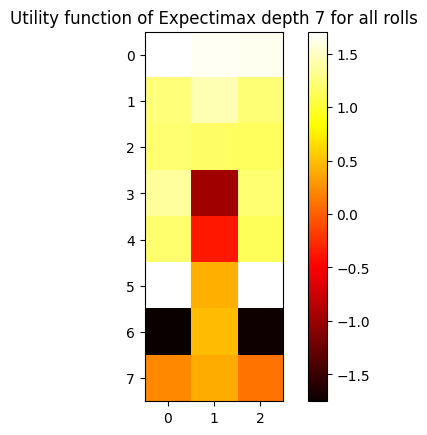

1682903


In [93]:
plt.imshow(df_all_rolls, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Utility function of Expectimax depth 7 for all rolls")
plt.show()
print(len(dataset))

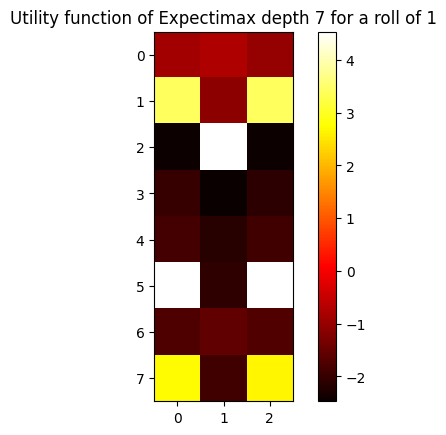

480572


In [95]:
plt.imshow(df_roll_1, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Utility function of Expectimax depth 7 for a roll of 1")
plt.show()
print(len(dataset.query("roll == 1")))

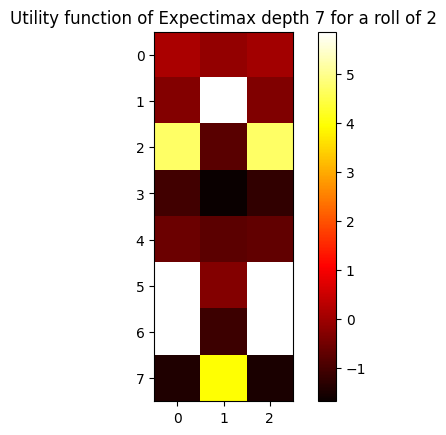

422058


In [96]:
plt.imshow(df_roll_2, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Utility function of Expectimax depth 7 for a roll of 2")
plt.show()
print(len(dataset.query("roll == 2")))

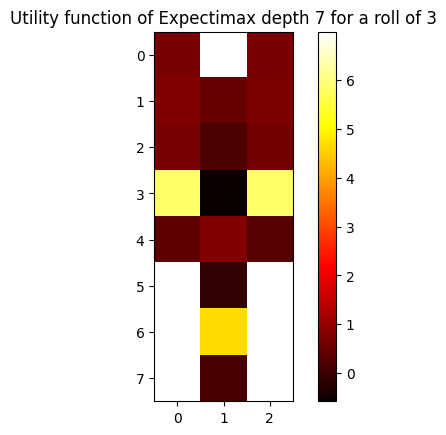

402456


In [97]:
plt.imshow(df_roll_3, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Utility function of Expectimax depth 7 for a roll of 3")
plt.show()
print(len(dataset.query("roll == 3")))

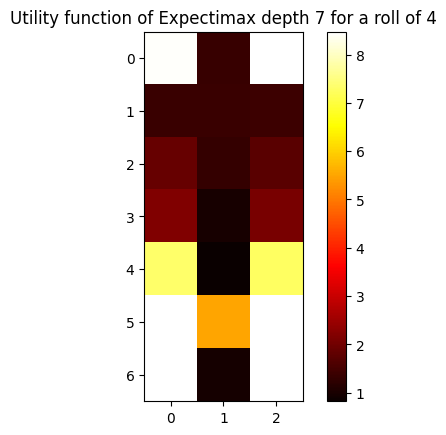

377817


In [98]:
plt.imshow(df_roll_4, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Utility function of Expectimax depth 7 for a roll of 4")
plt.show()
print(len(dataset.query("roll == 4")))

In [100]:
df_all_rolls = dataset.pivot_table(values='rank', index='y', columns='x')
df_roll_1 = dataset.query("roll == 1").pivot_table(values='rank', index='y', columns='x')
df_roll_2 = dataset.query("roll == 2").pivot_table(values='rank', index='y', columns='x')
df_roll_3 = dataset.query("roll == 3").pivot_table(values='rank', index='y', columns='x')
df_roll_4 = dataset.query("roll == 4").pivot_table(values='rank', index='y', columns='x')

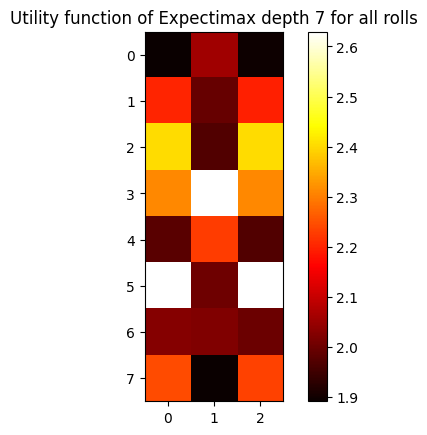

1682903


In [103]:
plt.imshow(df_all_rolls, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Ranking of pawn of Expectimax depth 7 for all rolls")
plt.show()
print(len(dataset))

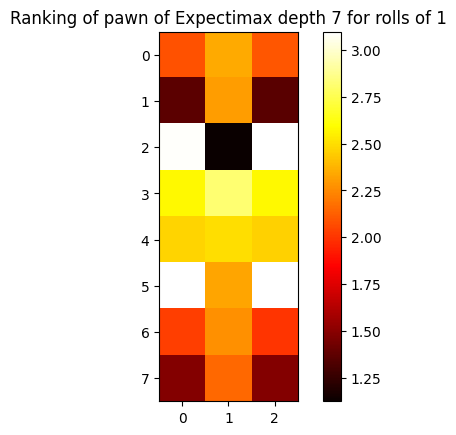

480572


In [105]:
plt.imshow(df_roll_1, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Ranking of pawn of Expectimax depth 7 for rolls of 1")
plt.show()
print(len(dataset.query("roll == 1")))

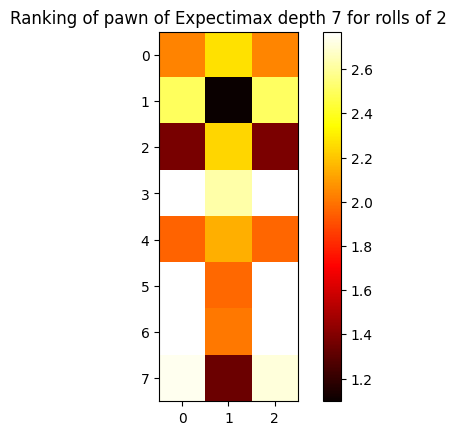

422058


In [106]:
plt.imshow(df_roll_2, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Ranking of pawn of Expectimax depth 7 for rolls of 2")
plt.show()
print(len(dataset.query("roll == 2")))

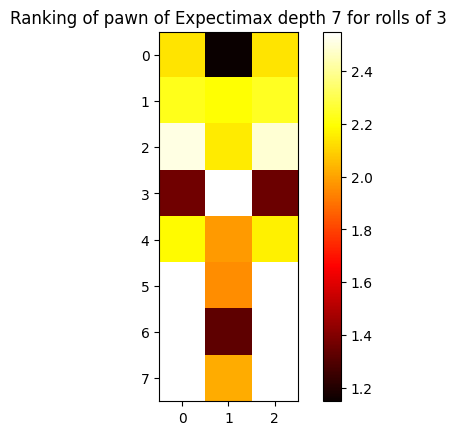

402456


In [107]:
plt.imshow(df_roll_3, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Ranking of pawn of Expectimax depth 7 for rolls of 3")
plt.show()
print(len(dataset.query("roll == 3")))

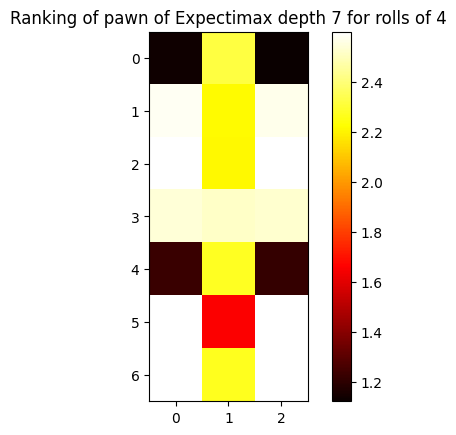

377817


In [108]:
plt.imshow(df_roll_4, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Ranking of pawn of Expectimax depth 7 for rolls of 4")
plt.show()
print(len(dataset.query("roll == 4")))